# Predicting Waterpoint Functionality in Tanzania

![img](images/lake_victoria.jpg)

(Lake Victoria in Tanzania - image courtesy of [thepinkbackpack.com](https://www.thepinkbackpack.com/).)

## Business Problem

**Business problem:** About 4 million of Tanzania's 59 million people lack access to potable (drinking) water; an even greater proportion of the Tanzanian population (nearly half) lack access to what water.org calls "[improved sanitation](https://water.org/our-impact/where-we-work/tanzania/)".

## Data

Data used in this classification project comes from an ongoing competition hosted by DrivenData, [*Pump it Up: Data Mining the Water Table*](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/). Descriptions of each column can be found at [this link](data_dict_basic.txt) within this repository.

In [125]:
# Packages for data cleaning, plotting, and manipulation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# scikit-learn libraries/functions/classes

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer

In [24]:
# Shows *all* columns in dataframe, i.e. does not truncate horizontally;
# feel free to comment out if undesired

pd.set_option('display.max_columns', None)

### Initial Data Cleaning and Comprehension

In [25]:
# Importing training data
train_val = pd.read_csv('data/training_set_values.csv')

# Only using `status_group` column from label set, to
# avoid duplicating `id` column
train_label = pd.read_csv('data/training_set_labels.csv',
                             usecols = ['status_group'])


# Test set - not to be used until models have been trained,
# internally validated, etc.
test_df = pd.read_csv('data/test_set_values.csv')

In [26]:
# Concatenating separate .csv files
df = pd.concat(objs = [train_val, train_label],
               axis = 1)

In [97]:
# Quick readout
df.sample(n = 5,
          random_state = 138)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
27487,60684,0.0,2013-02-15,Dwe,1137,DWE,37.136702,-4.075092,Madukani,0,Pangani,Madukani,Manyara,21,4,Simanjiro,Naberera,200,True,GeoData Consultants Ltd,VWC,Lendanai pipe scheme,True,1996,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
52964,457,0.0,2011-04-06,NaN,0,NaN,34.368774,-8.767996,Kwa Mzee Lusambo,0,Rufiji,Barabarani,Mbeya,12,7,Mbarali,Rujewa,0,False,GeoData Consultants Ltd,Water Board,NaN,True,0,gravity,gravity,gravity,water board,user-group,never pay,never pay,soft,good,seasonal,seasonal,river,river/lake,surface,communal standpipe,communal standpipe,non functional
26478,7855,50.0,2011-03-24,Private Individual,-8,Da,38.991011,-6.537616,Bakari,0,Wami / Ruvu,Mchanga Wa Kichwa A,Pwani,6,1,Bagamoyo,Zinga/Ikerege,30,True,GeoData Consultants Ltd,Company,Bagamoyo wate,True,2011,ksb,submersible,submersible,private operator,commercial,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59113,50299,0.0,2013-03-19,Government Of Tanzania,1068,DWE,36.806314,-3.448869,Kwa Elishirikiamwea Swai,0,Pangani,Upendo,Arusha,2,2,Arusha Rural,Mlangarini,150,True,GeoData Consultants Ltd,VWC,Machumba estate pipe line,True,1988,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,other,other,functional
14153,70382,0.0,2011-07-27,He,0,HE,31.635313,-1.718094,Kabubuya,0,Lake Victoria,Bubuya,Kagera,18,3,Muleba,Ijumbi,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,hand pump,hand pump,non functional


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

We have about **forty** potential features here, indicated by columns `0` through `39`; column `40`, `status_group`, is our target variable. The majority (30) of those columns  are currently stored as type `object`, the remainder as either `int64` or `float64`. Whether or not the numeric type columns contain continuous data will require further investigation.

In [28]:
# 59,400 rows of data in our training set
print(f'Train set: {df.shape[0]} rows')

# 14,850 rows of data in our test set
print(f'Test set: {test_df.shape[0]} rows')

Train set: 59400 rows
Test set: 14850 rows


In [101]:
# Checking datatypes of columns

df.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [31]:
# Descriptive stats on numerical columns

df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


**Takeaways:**
- `id` is purely an identifier - it's not going to be useful for modeling purposes.
- It's unlikely that `num_private` will be, either - we have a lot of data missing in this column (see the values for `min`, `25%`, `50%`, and `75%` in the descriptive statistics table), and the data dictionary has no articulation of what the values in this column actually indicate.
- `construction_year` has a `mean` heavily impacted by zero values; we'll need to handle this somehow.
- `gps_height`, `longitude`, and `latitude` are all numerical representations of location data.
- What unit is `population` in? We'll likely need to scale this; we also have a `max` value that's *well* above the `75%` value in that column.
    - The same applies for `amount_tsh`, which measures the total amount of water available to the waterpoint (the 'total static head')
- `region_code` and `district_code` look like discrete, categorical data.

#### Distribution of `y`

In [51]:
df.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

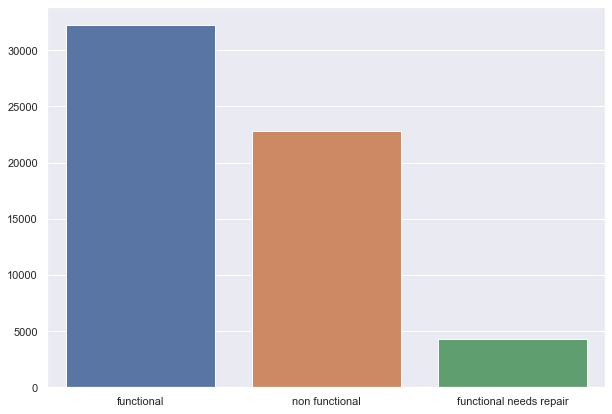

In [32]:
plt.figure(figsize=(10,7))

sns.set_theme()
sns.barplot(x = df.status_group.value_counts().index,
            y = df.status_group.value_counts().values);

The low number of records in the `functional needs repair` status group (~7.2% of the data) presents the challenge of a class imbalance; we may need to use something like synthetic minority oversampling i.e. `SMOTE` when modeling.

### Value Counts for Potential Feature Selection

#### Null value counts and columns

In [120]:
# Checking for null values in features columns

df.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

Columns/features with large numbers of **null values**, from least to greatest quantity:

- `subvillage` (371)
- `permit` (3056)
- `public_meeting` (3334)
- `funder` (3635)
- `installer` (3655)
- `scheme_management` (3877)
- `scheme_name` (28166) **(!)**

In [119]:
# Creating a list of columns with null values

has_nulls = []

for col in df:
    if df[col].isna().sum() != 0:
        has_nulls.append(col)

In [33]:
# What about duplicate rows?

df.duplicated().value_counts()

False    59400
dtype: int64

No duplicate rows - makes sense, given that this is a dataset curated for a competitiom.


Now, I'll look into the columns a little more. Since a lot of these columns are in `object` format, what's contained within them might not be immediately clear.

`basin` piqued my interest, and it's an easy way to take an exploratory dive into some categorical data, as my `.info()` indicated there are no null values in the `basin` column.

In [84]:
df.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

Nine categories in total for `basin`, each of which (other than `Internal`) represents a body of water. We can use sk-learn's `OneHotEncoder` transformer on this column.

Instinct tells me that the year a waterpoint was constructed might be a decent predictor of a waterpoint's functionality. Let's see what the most frequently occuring values for `construction_year` are in the dataset.

In [86]:
df.construction_year.value_counts().head(10)

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
Name: construction_year, dtype: int64

In [88]:
df.construction_year.value_counts().shape

(55,)

Records for 55 years, but the most common value is `0` - so probably more like 54 years, with waterpoints built between 2004 and 2011 making up the top ten most frequently occurring values. Though the pandas `.info()` and `.isna()` methods did not recognize any *null* values in the `construction_year` column, we have plenty of rows where `construction_year` was entered as `0`, which will require some munging/imputing.

In [81]:
print(f'Mean population: {np.mean(df.population.value_counts())}')
print(f'Median population: {np.median(df.population.value_counts())}')

Mean population: 56.625357483317444
Median population: 3.0


In [124]:
df.population.value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

In [100]:
df.loc[df.population == 0].sample(n = 5,
                                  random_state = 138)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
45592,13977,0.0,2011-03-26,Water,0,Gover,36.488600,-7.198751,Kisiwani,0,Rufiji,Vikundi,Dodoma,1,1,Mpwapwa,Ipera,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59371,20387,0.0,2012-10-09,Netherlands,0,DWE,33.586406,-3.040369,Ushirika,0,Lake Victoria,Chambwa,Shinyanga,17,2,Maswa,Kulimi,0,True,GeoData Consultants Ltd,WUG,NaN,False,0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
29587,21411,8000.0,2013-02-23,Songea District Council,1486,DWE,35.281597,-9.758611,Kwa George,0,Lake Nyasa,Mapinduzi A,Ruvuma,10,2,Songea Rural,Wino,0,True,GeoData Consultants Ltd,VWC,Mradi wa maji wa wino,True,2011,submersible,submersible,submersible,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
29704,8958,0.0,2011-04-04,Water,0,Commu,35.987864,-6.218267,Kwa Tangoo,0,Wami / Ruvu,Mnadani,Dodoma,1,5,Dodoma Urban,Kikombo,0,True,GeoData Consultants Ltd,VWC,Kiko,False,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
53568,65564,0.0,2011-03-23,Danida,1802,DWE,35.329705,-8.370343,none,0,Rufiji,I,Iringa,11,2,Mufindi,Luhunga,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


Hm - looks like instances where *one* zero was inputted, e.g. in the columns `construction_year` or `population`, other data is missing, too. Columns that may have inappropriately represented zero values (not initiually identified as nulls due to the way `.info()` recognizes null values) - include...

- `amount_tsh`
- `gps_height`
- `num_private`
- `population`
- `scheme_name`
- `construction_year`

Before we dig into dealing with those zeroes with imputation, let's look at the other columns that have `NaN` values.

In [108]:
has_nulls

['funder',
 'installer',
 'subvillage',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit']

In [134]:
print(df.installer.value_counts())
print('')
print(df.funder.value_counts())

DWE               17402
Government         1825
RWE                1206
Commu              1060
DANIDA             1050
                  ...  
Brad                  1
Matyenye              1
Paskali               1
MW                    1
Charlotte Well        1
Name: installer, Length: 2145, dtype: int64

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Misana George                1
Kamata Project               1
Maerere                      1
Tz As                        1
Trc                          1
Name: funder, Length: 1897, dtype: int64


Both `installer` and `funder` have several thousand rows with null values.

In [135]:
df.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [95]:
df.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [110]:
# nearly 3,000 unique `scheme_name` values and a load of nulls -
# unlikely this will make into to the modeling stage

print(df['scheme_management'].value_counts())
print('')
print(df['scheme_name'].value_counts())

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

K                        682
None                     644
Borehole                 546
Chalinze wate            405
M                        400
                        ... 
Msangani Dam               1
Rain Water Harvesting      1
Hale water suppy           1
Tove-mtwango               1
BL Kilimasimba             1
Name: scheme_name, Length: 2696, dtype: int64


In [37]:
# Enough data points in `communal standpipe multiple` to consider
# it a separate category from `communal standpipe`; no other differences

print(df['waterpoint_type'].value_counts())
print('')
print(df['waterpoint_type_group'].value_counts())

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


In [38]:
# salty/fluoride also have 'abandoned' specs in the `water_quality`
# column that are collapsed in the `quality_group` column;
# keeping `water_quality` due to proportions of 'abandoned'
# categories in the larger categories into which they fit (~10%)

print(df['water_quality'].value_counts())
print('')
print(df['quality_group'].value_counts())

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64


In [39]:
# These columns contain **identical** information; keeping `quantity`
# purely for purposes of readability

print(df['quantity'].value_counts())
print('')
print(df['quantity_group'].value_counts())

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64


In [40]:
# These columns contain identical information; `payment_type`
# is in a slightly more succinct format

print(df['payment'].value_counts())
print('')
print(df['payment_type'].value_counts())

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


In [41]:
# Nothing in `source` we can't garner from `source_type`
# and `source_class` -- the former is worth dropping

print(df['source'].value_counts())
print('')
print(df['source_type'].value_counts())
print('')
print(df['source_class'].value_counts())

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64


In [42]:
# Minor differences between these two

print(df['management'].value_counts())
print('')
print(df['management_group'].value_counts())

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64


#### Dropping irrelevant / redundant columns

In [43]:
# Dropping columns determined to be either irrelevant or
# superfluous in exploratory analysis

cols_to_drop = [
    'id',  # unique identifier, not useful for modeling
    'wpt_name',  # identifier column, not useful for modeling
    'num_private',  # data dict. does not provide details for this column
    'lga',
    'ward',  # redundant location data (with `lga`)
    'scheme_name',  # large number of nulls, redundant vis-a-vis `scheme_management`
    'extraction_type',
    'extraction_type_group',  # using `extraction_type_class` for generalized info
    'payment',  # identical information to `payment_type`
    'quality_group',  # comparable information to `water_quality` - redundant
    'quantity_group',  # identical information to `quantity` - redundant
    'source',  # redundant with other `source_` columns
    'waterpoint_type_group'  # used `waterpoint_type` instead
]

## Preprocessing

### Pipelines: Scaling and Encoding

Necessary modifications for modeling, to be written into pipelines:

- One-hot encoding:
    - `basin`
    - `payment_type`
- Numerical scaling:
    - `population` - (impute zeroes with median?)
    - `gps_height` - impute zeroes with median
    - `latitude` / `longitude` - impute zeroes with mean
    - `construction_year` - use KNN imputing
    
Our target variable, `status_group`, will also be **label encoded** for readability and consistency:
- `0` = 'functional'
- `1` = 'non functional'
- `2` = 'functional needs repair'

#### Subpipe Creation

In [154]:
# Subpipes for imputing KNN values - to be used for `latitude` and `longitude`
subpipe_lat      = Pipeline(steps=[('num_impute', KNNImputer(missing_values = -2.000000e-08)),
                                   ('ss', StandardScaler())])

subpipe_long     = Pipeline(steps=[('num_impute', KNNImputer(missing_values = 0.000000)),
                                   ('ss', StandardScaler())])


# Subpipe for imputing median values
subpipe_num      = Pipeline(steps=[('num_impute', SimpleImputer(strategy = 'median')),
                                   ('ss', StandardScaler())])

# Subpipe for `construction_year`
subpipe_year     = Pipeline(steps=[('num_impute', KNNImputer(missing_values = 0)),
                                   ('ss', StandardScaler())])

# Subpipe for categorical features including `basin`, `payment_type`
subpipe_cat      = Pipeline(steps=[('knn_impute', KNNImputer(missing_values = 'unknown')),
                                   ('freq_impute', SimpleImputer()),
                                   ('ohe', OneHotEncoder(sparse = False,
                                                         handle_unknown = 'ignore'))])


# Subpipe for the target column, `status_group`
subpipe_label    = Pipeline(steps=[('le', LabelEncoder())])

#### `ColumnTransformer`

In [155]:
num_cols = ['population', 'gps_height', 'amount_tsh']
cat_cols = ['basin', 'payment_type', 'quantity', 'water_quality',
            'permit', 'public_meeting', 'extraction_type_class',
            'source_type', 'source_class']

In [164]:
ct = ColumnTransformer(transformers = [
    ('subpipe_lat', subpipe_lat, 'latitude'),
    ('subpipe_long', subpipe_lat, 'longitude'),
    ('subpipe_num', subpipe_num, num_cols),
    ('subpipe_year', subpipe_year, 'construction_year'),
    ('subpipe_cat', subpipe_cat, cat_cols),
#     ('subpipe_label', subpipe_label, 'status_group')
    
])

In [165]:
dummy_model_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier())
])

In [166]:
linreg_model_pipe = Pipeline(steps=[
    ('ct', ct),
    ('logreg', LogisticRegression(random_state = 138))
])

### Train/Test Split and Initial Preparation for ML

In [167]:
# Splitting DataFrame into features/values DataFrame
# (i.e. `X`) and labels series (`y`)

X = df.drop('status_group', axis = 1)
y = df['status_group']

In [168]:
# Splitting internal training data into separate
# training and test sets for (eventual) internal validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 138)

## Modeling

### Dummy Model

In [73]:
# # Instantiate and assign to variable
# dc = DummyClassifier()

# # Fit on training data
# dc.fit(X_train, y_train)

# # Score on training data
# dc.score(X_train, y_train)

0.5420875420875421

In [158]:
dummy_model_pipe.score(X_train, y_train)

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

scikit-learn's `DummyClassifier` predicts on the training data with an accuracy score of ~0.542, equal to the proportion of the **most frequent class** (`functional`). This is because, as a dummy model, it predicts `functional` (the most frequent value) every time.

We'll be looking to improve on that 54.2% accuracy in future models.

### Simple Model 1

In [69]:
# logreg = LogisticRegression()

### GridSearch

### Simple Model 2

In [ ]:
# dcf = DecisionTreeClassifier(max_depth=20)

# Scrap Code / Brainstorming

Considering cutting:

- `region` / `lga` / `ward` - what does the quality of a waterpoint have to do with geographic borders, unless it's identifying what regions are particularly "good" at upkeep?
- `scheme_management` and `scheme_name` - not particularly descriptive
- `funder` / `installer` - thousands of potential columns, large concentrations in the top 3-5 funders/installers

In [ ]:
# X.loc[X['funder'].isna()].head();